# Componente de machine learning do Spark MLlib
* Acesso a dados
* Regressão, classificação e agrupamento com Spark

In [ ]:
from pyspark.ml.regression import LinearRegression

from pyspark.sql import SparkSession

# ponto de entrada - sessão spark

In [ ]:
spark = SparkSession \
    .builder \
    .appName("Python Spark SQL basic example") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

# exemplo de operação com dataframe

In [ ]:
df = spark.read.json("pessoas.json")
df.show()

# Algumas operações com dataframe

In [ ]:
# Print schema
df.printSchema()

# selecione apenas a coluna nome
df.select("nome").show()

# seleciona todo mundo e adiciona 1 a idade
df.select(df['nome'], df['idade'] + 1).show()

# filtra apenas maiores de 21
df.filter(df['idade'] > 21).show()

# Conta pessoas por idade
df.groupBy("idade").count().show()

# regressao linear com PySpark
* Preparação de dados

In [ ]:
#carregando CSV
training = spark.read.load("Auto2.csv",
                     format="csv", sep=",", inferSchema="true", header="true")

training.show()

# regressao linear com PySpark
* Indexando para coluna categórica

In [ ]:
from pyspark.ml.feature import StringIndexer

indexer=StringIndexer(inputCol='origin',outputCol='origin_cat')
indexed=indexer.fit(training).transform(training)
indexed.show()

# regressao linear com PySpark
* Separando entre features e target

In [ ]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

#input cols identifica features
assembler=VectorAssembler(inputCols=['cylinders','displacement','horsepower','weight','acceleration','year','origin_cat']
                          ,outputCol='features')

output=assembler.transform(indexed)
output.select('features','mpg').show(5)

# regressao linear com PySpark
* Separa em treino e teste

In [ ]:

final_data=output.select('features','mpg')
train_data,test_data=final_data.randomSplit([0.7,0.3])
train_data.describe().show()

# regressao linear com PySpark
* Executa o modelo

In [ ]:

from pyspark.ml.regression import LinearRegression

lr=LinearRegression(featuresCol='features',labelCol='mpg')

model=lr.fit(train_data)

results=model.evaluate(train_data)
  
print('Rsquared :',results.r2)

In [ ]:
unlabeled_data=test_data.select('features')
unlabeled_data.show(5)

In [ ]:
predictions=model.transform(unlabeled_data)
predictions.show()

# classificação com pyspark

In [ ]:
#carregando CSV
diab = spark.read.load("pima-indians-diabetes.csv",
                     format="csv", sep=",", inferSchema="true", header="true")

diab.show()

In [ ]:
assembler=VectorAssembler(inputCols=['Pregnancies','Glucose','BloodPressure','SkinThickness','Insulin','BMI','DiabetesPedigreeFunction','Age']
                          ,outputCol='features')

output=assembler.transform(diab)
output.select('features','Class').show(5)

In [ ]:
final_data=output.select('features','Class')
train_data,test_data=final_data.randomSplit([0.7,0.3])
train_data.describe().show()

In [ ]:
from pyspark.ml.classification import LogisticRegression

logr = LogisticRegression(featuresCol='features', labelCol='Class')

model=logr.fit(train_data)

results=model.evaluate(train_data)
  
#print('Rsquared :',results.r2)

In [ ]:
predictions = model.transform(test_data)
predictions.select( 'Class', 'rawPrediction', 'prediction', 'probability').show(50)

# Kmeans Spark
* Preparando dados

In [7]:
import numpy as np

import matplotlib.pyplot as plt

from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import SparkSession

from pyspark.ml.feature import StandardScaler

import datetime

spark = SparkSession.builder.appName('SparkKmeans').getOrCreate()

df2 = spark.read.load("/home/silvio/dataset/minute_weather.csv",
                     format="csv", sep=",", inferSchema="true", header="true")
                     
df = df2.drop("rowID","hpwren_timestamp")

df = df.fillna(0)

vecAssembler = VectorAssembler(inputCols=df.columns, outputCol="features")
vector_df = vecAssembler.transform(df)

scale=StandardScaler(inputCol='features',outputCol='standardized')
data_scale=scale.fit(vector_df)
data_scale_output=data_scale.transform(vector_df)
data_scale_output.show(2)




+------------+--------+------------------+--------------+------------------+--------------+------------------+--------------+-----------------+-------------+-----------------+--------------------+--------------------+
|air_pressure|air_temp|avg_wind_direction|avg_wind_speed|max_wind_direction|max_wind_speed|min_wind_direction|min_wind_speed|rain_accumulation|rain_duration|relative_humidity|            features|        standardized|
+------------+--------+------------------+--------------+------------------+--------------+------------------+--------------+-----------------+-------------+-----------------+--------------------+--------------------+
|       912.3|   64.76|              97.0|           1.2|             106.0|           1.6|              85.0|           1.0|              0.0|          0.0|             60.5|[912.3,64.76,97.0...|[298.958597076191...|
|       912.3|   63.86|             161.0|           0.8|             215.0|           1.5|              43.0|           0.2|   

# Kmeans Spark
* silhouette_score

In [8]:
B=datetime.datetime.now()

silhouette_score=[]
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='standardized', \
                                metricName='silhouette', distanceMeasure='squaredEuclidean')
for i in range(2,15):
    
    KMeans_algo=KMeans(featuresCol='standardized', k=i)
    
    KMeans_fit=KMeans_algo.fit(data_scale_output)
    
    output=KMeans_fit.transform(data_scale_output)
    
    
    
    score=evaluator.evaluate(output)
    
    silhouette_score.append(score)
    
    print("Silhouette Score:",score)

E=datetime.datetime.now()
print(E-B)

Silhouette Score: 0.4211655867275146
Silhouette Score: 0.4034984633421886
Silhouette Score: 0.37641930813545926
Silhouette Score: 0.35125589464171564
Silhouette Score: 0.3777784548298312
Silhouette Score: 0.4156833921340365
Silhouette Score: 0.4071414772609614
Silhouette Score: 0.4122555475431301
Silhouette Score: 0.3721676652461534
Silhouette Score: 0.35060642780802115
Silhouette Score: 0.37491188004538445
Silhouette Score: 0.3825610460365306
Silhouette Score: 0.36773084077574986
0:02:14.416311


In [9]:
# visualização do silhouette_score

Text(0, 0.5, 'custo')

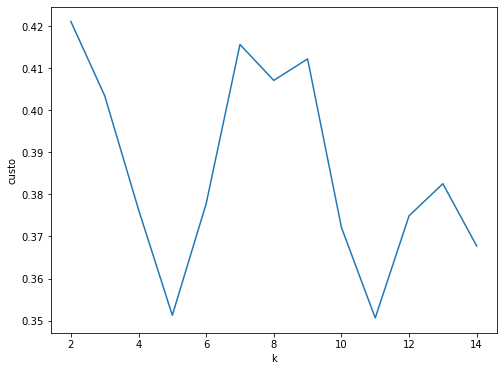

In [10]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,15),silhouette_score)
ax.set_xlabel('k')
ax.set_ylabel('custo')
